<center >
    <h1 > OneShot Learning for image data </h1>
</center>
<br><br>

We will be implementing the oneshot learning algorithm here just like the [FaceNet](https://arxiv.org/pdf/1503.03832.pdf) and [Deepface](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf) in order to combine images of a similar kind in the dataset. For achieving this, we will be using the ResNet architecture for forward propogation through the images and generate a image embedding unique to only the specific images in the dataset.

A rough idea about oneshot learning could be found here in this image:

<br>
![Oneshot learning](https://sorenbouma.github.io/images/Siamese_diagram_2.png)
<br>
The procedure in the image is explained using classic Alexnet convolutional architecture, but in this notebook I have implemented Google's Inception model as it turns out to be faster than few other deep network architectures.

In [1]:
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input
from keras.models import Model, Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.applications.inception_v3 import InceptionV3
from keras.models import load_model
import cv2
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import time

Using TensorFlow backend.


### Initializing the model.
The image size we will be using here is 200X200 as the ResNet50 requires us to have this size of images atleast

In [0]:
RecModel = InceptionV3(input_shape=(200,200,3), weights=None, include_top=False)

### Triplet loss

Triplet loss is nothing but the eucledian distance between the ***<abbr title="The image on which we have to compare with.">anchor</abbr>*** and the ***<abbr title="Image that is exactly the same as anchor image">positive</abbr> *** and ***<abbr title="The image that is not similar to the achor image">negetive</abbr>*** images.  
I have refered to [this awesome](https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24) article on triplet loss from [TowardsDataScience](https://towardsdatascience.com/). Everything a triplet loss does could be jotted down to this image.

![Triplet Loss](https://cdn-images-1.medium.com/max/889/0*_WNBFcRVEOz6QM7R.)

In [0]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive))
    neg_dist = tf.reduce_sum(tf.square(anchor - negative))
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.maximum(basic_loss, 0)    
    return loss

In [0]:
RecModel.compile(optimizer='adam', loss = triplet_loss, metrics = ['accuracy'])

In [11]:
# Download the images previously uploaded in data-extraction notebook. 
# These link will work till 13 Oct 2018 and should be changed by running the preprocessing notebook added with this unit.

!wget https://transfer.sh/ShBts/images_fkcdn.zip 
!wget https://transfer.sh/8gQj4/tunics.csv
!unzip images_fkcdn.zip

--2018-10-04 19:19:58--  https://transfer.sh/ShBts/images_fkcdn.zip
Resolving transfer.sh (transfer.sh)... 185.216.24.82
Connecting to transfer.sh (transfer.sh)|185.216.24.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300797777 (287M) [application/zip]
Saving to: ‘images_fkcdn.zip’

images_fkcdn.zip    100%[===================>] 286.86M  20.0MB/s    in 18s     

2018-10-04 19:20:17 (16.1 MB/s) - ‘images_fkcdn.zip’ saved [300797777/300797777]

--2018-10-04 19:20:19--  https://transfer.sh/8gQj4/tunics.csv
Resolving transfer.sh (transfer.sh)... 185.216.24.82
Connecting to transfer.sh (transfer.sh)|185.216.24.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49915831 (48M) [text/csv]
Saving to: ‘tunics.csv.1’

tunics.csv.1        100%[===================>]  47.60M  10.5MB/s    in 5.3s    

2018-10-04 19:20:25 (9.00 MB/s) - ‘tunics.csv.1’ saved [49915831/49915831]

Archive:  images_fkcdn.zip
replace images/TUNEAVFPXPVEEPJD.jpg? [y]es

In [0]:
#Image encoding. The main aim of this function is to convert the images to encodings.
def image_to_encoding(image_name, model):
    #Read the image and convert BGR to RGB
    a = cv2.imread('./images/'+str(image_name),cv2.COLOR_BGR2RGB)
    
    #Generate the image padding using np.zeros
    b = np.zeros((200,200,3), dtype='uint8')
    
    #Add the slice of image over the padding
    b[:a.shape[0],:a.shape[1],:]+=a
    
    #Convert to batch
    b = b.reshape(1,200,200,3)
    
    #Forward propagate through the model network
    embedding = model.predict_on_batch(b)
    
    return embedding

In [14]:
# Function to check the speed of model on a single image.
start=time.time()
image_to_encoding('TUNE94FTWTSPGGGE.jpg', RecModel)
print((time.time()-start))

0.151872873306


In [0]:
imgs = os.listdir('./images')
database={}
for i,img in enumerate(sorted(imgs)):
    if i%100==0:
        print(i) #This could be replaced by TQDM for visual representations
    database[img.split('.')[0]]=image_to_encoding(img, RecModel)

In [0]:
#Function to verify the images with the identity
def verify(image,identity, database, model):
    """
    Function that verifies Redundant images
    
    Arguments:
    image_path -- path to an image
    identity -- string, productId you'd like to verify the identity.
    database -- python dictionary mapping Products to their encodings (vectors).
    model -- your ResNet model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    same -- True, if the images are same. False otherwise.
    """
    
    # Step 1: Compute the encoding for the image. Use image_to_encoding()
    encoding = image_to_encoding(image, model)
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(database[identity] - encoding)
    
    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist < 1:
        same = True
    else:
        same = False
        
    return dist, same

In [0]:
a1 = 'TUNEY2FZVC4DQV6Z.jpg' #Similar as below image
b1 = 'TUNEY2FZXJZQE3SC.jpg' #Similar as above image
c1 = 'TUNEGVMQEV6FQFYC.jpg' #Different image
a = cv2.imread('./images/'+a1, cv2.COLOR_BGR2RGB)
b = cv2.imread('./images/'+b1, cv2.COLOR_BGR2RGB)
c = cv2.imread('./images/'+c1, cv2.COLOR_BGR2RGB)

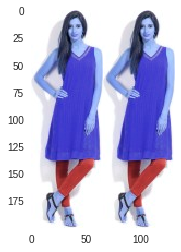

In [20]:
h = max(a.shape[0], b.shape[0])
w = a.shape[1]+b.shape[1]
cimg = np.zeros((h,w,3), dtype='uint8')
cimg[:h,:a.shape[1],:]+=a
cimg[:h,a.shape[1]:,:]+=b
plt.grid(False)
plt.imshow(cimg)

In [27]:
print(verify(a1, b1.split('.')[0], database, RecModel))[1]
# should return true as a == b

True


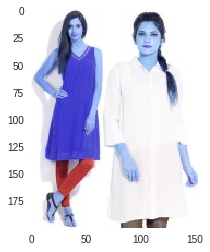

In [16]:
h = max(a.shape[0], c.shape[0])
w = a.shape[1]+c.shape[1]
cimg = np.zeros((h,w,3), dtype='uint8')
cimg[:h,:a.shape[1],:]+=a
cimg[:h,a.shape[1]:,:]+=c
plt.grid(False)
plt.imshow(cimg)

In [28]:
print(verify(a1, c1.split('.')[0], database, RecModel))[1]
#Should return false as a!=c

False


In [0]:
df = pd.read_csv('tunics.csv')

In [24]:
df.columns

Index([u'Unnamed: 0', u'productId', u'title', u'description', u'imageUrlStr',
       u'mrp', u'sellingPrice', u'specialPrice', u'productUrl', u'categories',
       u'productBrand', u'productFamily', u'inStock', u'codAvailable',
       u'offers', u'discount', u'shippingCharges', u'deliveryTime', u'size',
       u'color', u'sizeUnit', u'storage', u'displaySize', u'keySpecsStr',
       u'detailedSpecsStr', u'specificationList', u'sellerName',
       u'sellerAverageRating', u'sellerNoOfRatings', u'sellerNoOfReviews',
       u'sleeve', u'neck', u'idealFor'],
      dtype='object')

In [0]:
productFamily={} #Product family dictionary
for i in range(len(df['productId'])):
    productFamily[df['productId'][i]]=df['productFamily'][i].split(',')

In [0]:
#Compare each image with all other image in array

imgs=sorted(imgs) #Gets sorted images 
checks={}
ptr=0

# This loops compares the image with the preceeding images and 
# not with the already visited images to overcome redundancy
for i in range(len(imgs)):
    anchor_image=imgs[i]
    anchor_name=imgs[i].split('.')[0]
    checks[anchor_name]=[]
    start=time.time()
    for j in range(i+1,len(imgs)):
        target_image=imgs[j]
        target_name=imgs[j].split('.')[0]
        if target_name not in productFamily[anchor_name] and verify(anchor_image, target_name, database, RecModel)[1] :
            checks[anchor_name].append(target_name)
            print(ptr)
            ptr+=1
    print(time.time()-start)
    
#  This Loop causes N^2 complexity and would take around 5.25 days to compare, 
# so I discarded this method and moved to the next method.

In [0]:
# Dump the json to the temp server
import json
with open('output.json','w') as f:
    json.dump(check,f)
    
!curl --upload-file ./output.json https://transfer.sh/output.json 

This notebook is supposed to run just fine on an even smaller dataset as this will take about 9 days of training time and lots of computation power to train, I could not complete the training after I was able to figure out the most appropriate method and created my own model for the same.

I am even working on a next notebook that might come as solution the time complexity problem. Hope it works